## Surrogate-Based Operability Analysis of a Shower System

Author: Rafael Heilbuth, Federal University of Uberlândia (PhD Student)

This notebook introduces the use of **surrogate models** for process operability analysis. Surrogates are data-driven approximations of process models that can be used in place of first-principles models. Here, we use **Gaussian Process (GP)** regression to build a surrogate and demonstrate the complete workflow for training, validating, and using it with opyrability's analysis tools.

The shower system mixes hot and cold water streams to achieve desired total flow rate and temperature specifications (see the [Shower Problem](operability_index_shower.ipynb) example for reference).

**Variables:**

| Input (AIS) | Output (AOS) |
|---|---|
| Cold Water Flow | Total Flow |
| Hot Water Flow | Temperature |

### First-Principles Model

The shower model is defined by mass and energy balances:

- **Total flow:** $F_{total} = F_{cold} + F_{hot}$
- **Outlet temperature:** $T_{out} = \frac{F_{cold} \cdot T_{cold} + F_{hot} \cdot T_{hot}}{F_{total}}$

where $T_{cold} = 60$ and $T_{hot} = 120$.

In [22]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import qmc
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [23]:
# Temperature constants
T_cold = 60   # Cold water temperature
T_hot = 120   # Hot water temperature


def shower_model(u):
    """First-principles model: maps flow inputs to outputs.
    
    Args:
        u: [Cold Water Flow, Hot Water Flow]
    
    Returns:
        [Total Flow, Temperature]
    """
    F_cold, F_hot = u[0], u[1]
    F_total = F_cold + F_hot
    T_out = (F_cold * T_cold + F_hot * T_hot) / F_total if F_total > 0 else 90
    return np.array([F_total, T_out])


# Verify model works
test_output = shower_model(np.array([5.0, 5.0]))
print(f"Test point (F_cold=5, F_hot=5):")
print(f"  Total Flow: {test_output[0]:.2f}")
print(f"  Temperature: {test_output[1]:.2f}")

Test point (F_cold=5, F_hot=5):
  Total Flow: 10.00
  Temperature: 90.00


### Training Data Generation

We generate training data using **Latin Hypercube Sampling (LHS)**, which provides better coverage of the input space compared to random sampling.

| Variable | Lower Bound | Upper Bound |
|---|---|---|
| Cold Water Flow | 1 | 10 |
| Hot Water Flow | 1 | 10 |

In [24]:
# Define AIS bounds and generate LHS samples
u_min = np.array([1, 1])    # Lower bounds [F_cold, F_hot]
u_max = np.array([10, 10])  # Upper bounds [F_cold, F_hot]
n_samples = 50

sampler = qmc.LatinHypercube(d=2, seed=42)
samples_unit = sampler.random(n=n_samples)
X_samples = qmc.scale(samples_unit, u_min, u_max)

print(f"Generated {n_samples} LHS samples")
print(f"  Cold Flow range: [{X_samples[:,0].min():.2f}, {X_samples[:,0].max():.2f}]")
print(f"  Hot Flow range: [{X_samples[:,1].min():.2f}, {X_samples[:,1].max():.2f}]")

Generated 50 LHS samples
  Cold Flow range: [1.16, 9.90]
  Hot Flow range: [1.04, 9.95]


In [25]:
# Evaluate first-principles model on all samples
Y_samples = np.array([shower_model(x) for x in X_samples])

# Train/Test split (40 train, 10 test)
np.random.seed(42)
indices = np.random.permutation(n_samples)
n_train = 40

X_train, X_test = X_samples[indices[:n_train]], X_samples[indices[n_train:]]
Y_train, Y_test = Y_samples[indices[:n_train]], Y_samples[indices[n_train:]]

print(f"Training set: {n_train} samples")
print(f"Test set: {n_samples - n_train} samples")

Training set: 40 samples
Test set: 10 samples


### GP Model Training & Validation

We train separate GP models for each output using scikit-learn's `GaussianProcessRegressor`. The inputs are standardized and we use a squared exponential (RBF) kernel.

In [26]:
# Standardize inputs
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train GP models
kernel = ConstantKernel(1.0) * RBF(length_scale=[1.0, 1.0])

gpr_flow = GaussianProcessRegressor(
    kernel=kernel, alpha=1e-8, n_restarts_optimizer=5, random_state=42, normalize_y=True
)
gpr_flow.fit(X_train_scaled, Y_train[:, 0])

gpr_temp = GaussianProcessRegressor(
    kernel=kernel, alpha=1e-8, n_restarts_optimizer=5, random_state=42, normalize_y=True
)
gpr_temp.fit(X_train_scaled, Y_train[:, 1])

# Validate on test set
Y_pred_flow = gpr_flow.predict(X_test_scaled)
Y_pred_temp = gpr_temp.predict(X_test_scaled)

print("Validation Results (Hold-out Test Set):")
print(f"  Total Flow:   R² = {r2_score(Y_test[:, 0], Y_pred_flow):.6f}, "
      f"RMSE = {np.sqrt(mean_squared_error(Y_test[:, 0], Y_pred_flow)):.6f}")
print(f"  Temperature:  R² = {r2_score(Y_test[:, 1], Y_pred_temp):.6f}, "
      f"RMSE = {np.sqrt(mean_squared_error(Y_test[:, 1], Y_pred_temp)):.6f}")

Validation Results (Hold-out Test Set):
  Total Flow:   R² = 1.000000, RMSE = 0.000002
  Temperature:  R² = 0.999992, RMSE = 0.032244


### Surrogate Model Function

We create a wrapper function that combines both GP models. This function has the same signature as the original model and can be used directly with opyrability.

In [27]:
def gp_surrogate(u):
    """GP surrogate model for shower system.
    
    Args:
        u: [Cold Water Flow, Hot Water Flow]
    
    Returns:
        [Total Flow, Temperature]
    """
    u_scaled = scaler_X.transform(np.atleast_2d(u))
    flow_pred = gpr_flow.predict(u_scaled)[0]
    temp_pred = gpr_temp.predict(u_scaled)[0]
    return np.array([flow_pred, temp_pred])


# Quick verification
test_u = np.array([5.0, 5.0])
fp_result = shower_model(test_u)
gp_result = gp_surrogate(test_u)
print(f"Verification at u = [5.0, 5.0]:")
print(f"  First-Principles: Flow = {fp_result[0]:.4f}, Temp = {fp_result[1]:.4f}")
print(f"  GP Surrogate:     Flow = {gp_result[0]:.4f}, Temp = {gp_result[1]:.4f}")

Verification at u = [5.0, 5.0]:
  First-Principles: Flow = 10.0000, Temp = 90.0000
  GP Surrogate:     Flow = 10.0000, Temp = 90.0030


### Inverse Mapping with GP Surrogate

With the surrogate trained and validated, we can use it for operability analysis. Here we perform **inverse mapping** to find the input region (DIS*) that achieves a desired output specification (DOS).

**Desired Output Set (DOS):**
- Total Flow: 2–20
- Temperature: 70–110

In [28]:
from opyrability import nlp_based_approach

# Define DOS, bounds, and initial estimate
DOS_bounds = np.array([[2, 20],     # Total Flow
                       [70, 110]])  # Temperature
DOS_resolution = [10, 10]

u0 = np.array([5, 5])  # Initial estimate

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


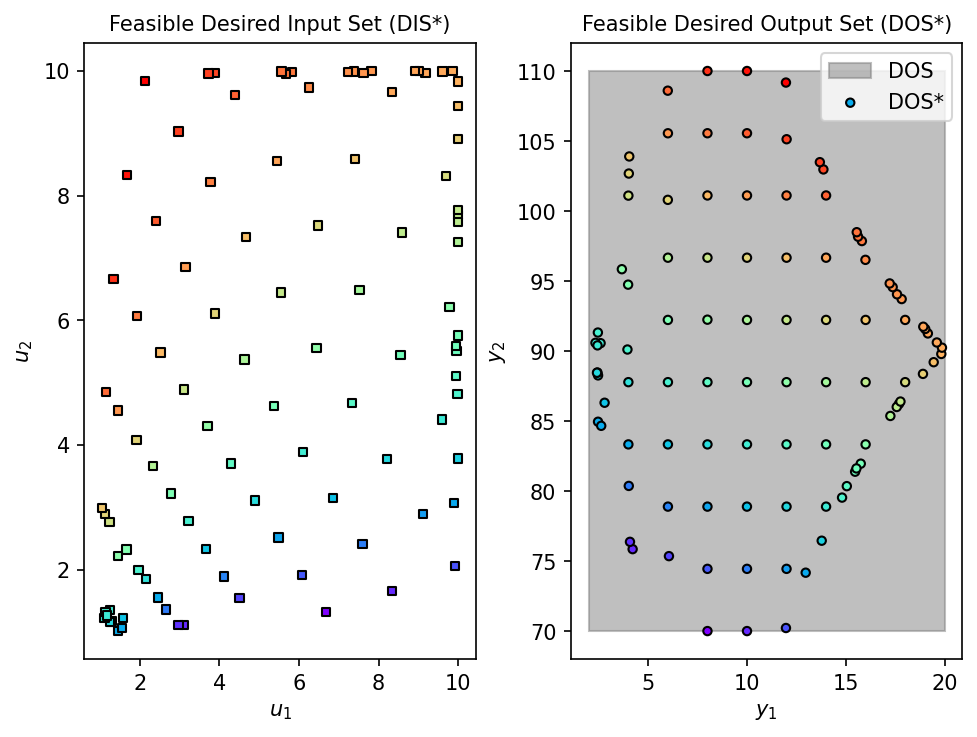

In [29]:
# Inverse mapping with GP Surrogate
fDIS_surr, fDOS_surr, conv_surr = nlp_based_approach(
    gp_surrogate, DOS_bounds, DOS_resolution, u0, u_min, u_max,
    method='trust-constr', plot=True, ad=False, warmstart=True
)

### Operability Index Evaluation

The **Operability Index (OI)** quantifies what fraction of the DOS is achievable. We compute it using both the surrogate and the first-principles model to verify the surrogate's accuracy.

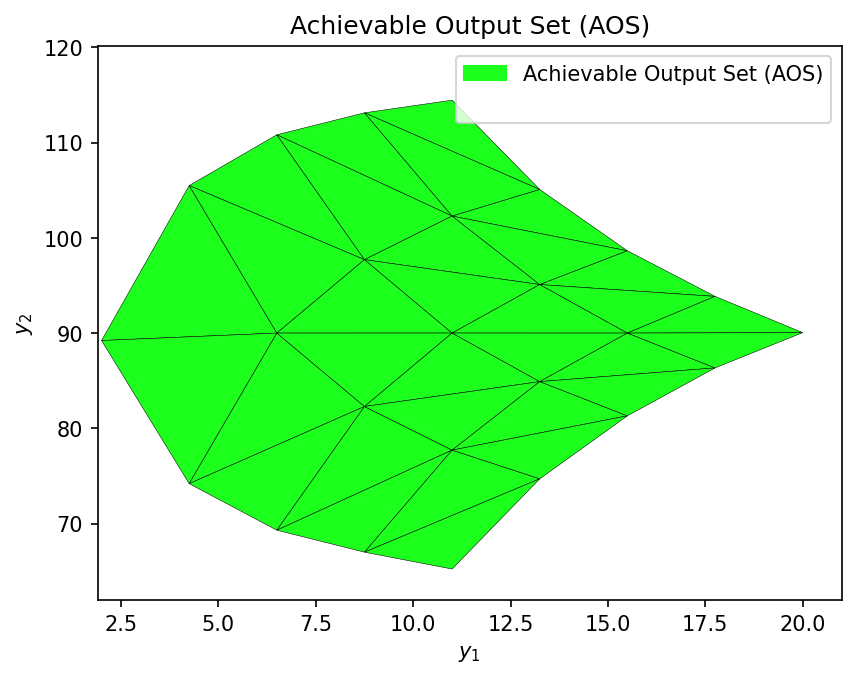

In [30]:
from opyrability import multimodel_rep, OI_eval

# Define AIS for multimodel representation
AIS_bounds = np.array([[1, 10], [1, 10]])
AIS_resolution = [5, 5]

# Compute AOS with GP surrogate
AOS_surr = multimodel_rep(gp_surrogate, AIS_bounds, AIS_resolution)

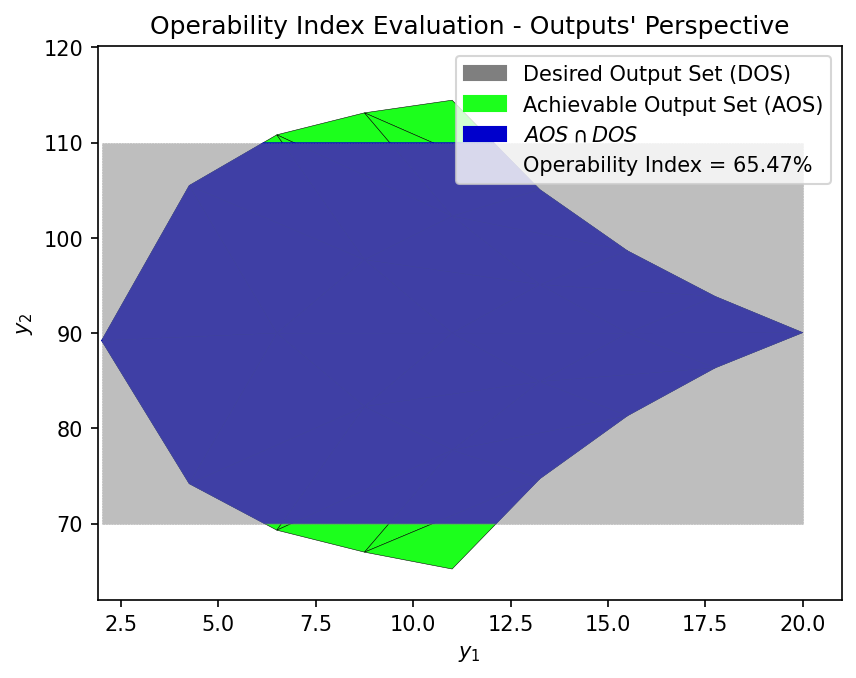

In [31]:
OI_surr = OI_eval(AOS_surr, DOS_bounds, plot=True)

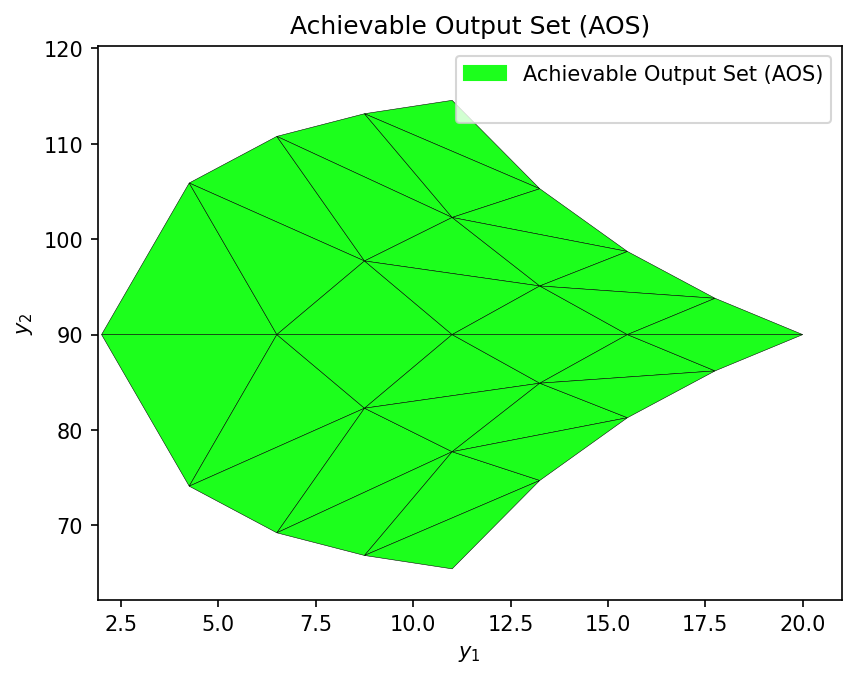

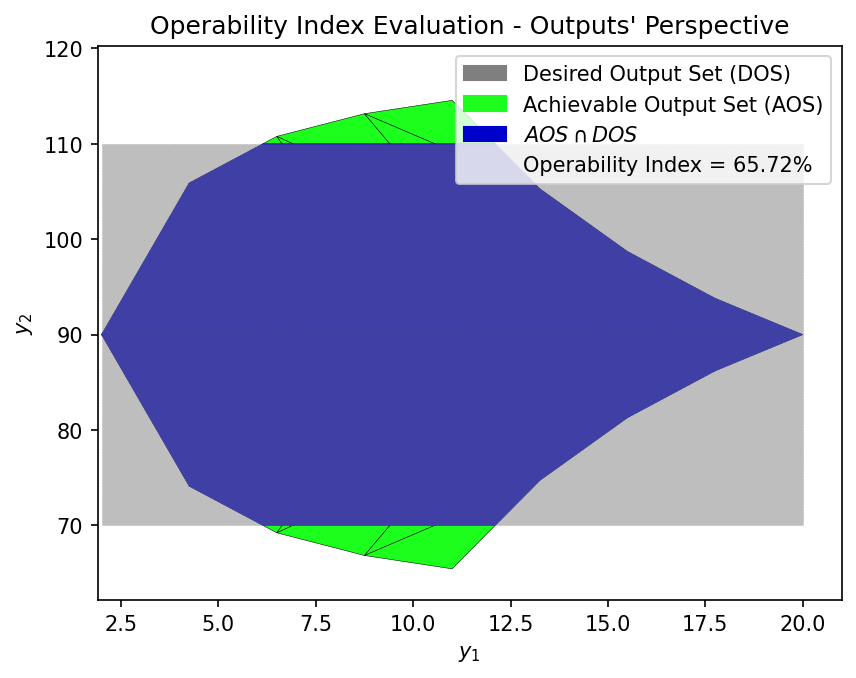

In [32]:
# Compare with first-principles model
AOS_fp = multimodel_rep(shower_model, AIS_bounds, AIS_resolution)
OI_fp = OI_eval(AOS_fp, DOS_bounds, plot=True)

In [33]:
# OI Comparison Summary
print("=" * 50)
print("OPERABILITY INDEX COMPARISON")
print("=" * 50)
print(f"\n  First-Principles OI: {OI_fp:.2f}%")
print(f"  GP Surrogate OI:     {OI_surr:.2f}%")
print(f"\n  Relative Error: {abs(OI_fp - OI_surr) / OI_fp * 100:.2f}%")

OPERABILITY INDEX COMPARISON

  First-Principles OI: 65.72%
  GP Surrogate OI:     65.47%

  Relative Error: 0.39%


### Conclusions

This example demonstrated the workflow for using GP surrogates with opyrability:

1. **Generate training data** from the process model using Latin Hypercube Sampling
2. **Train GP models** for each output variable
3. **Validate** the surrogate on a hold-out test set
4. **Create a wrapper function** with the same interface as the original model
5. **Use opyrability functions** (inverse mapping, OI evaluation) with the surrogate

The surrogate achieved excellent accuracy (R² > 0.999) and produced OI values nearly identical to the first-principles model.

For a more advanced example using JAX for automatic differentiation, see the [GP Surrogate DMA-MR example](gp_surrogate_dma-mr.ipynb).